**DataEval Pruning and Prioritization Deep Dive**


Today, we will be showing off two new prototyped features in DataEval: dataset pruning and dataset prioritization.


**Pruning**


Often, when we have very large datasets, there is redundency in underlying signal. While some overlap in information can convey underlying covariate frequencies, too much repeated information can be a large computational and logistical burden. The _pruning_ tool seeks to mitigate this problem by identifying a subset of the data that is no less informative than the orginal dataset.


![alt text](figs/workflow.png "Title")


In [1]:
from matplotlib import pyplot as plt
from prioritization import KNNSorter, get_pruned_dataset, prioritize
from dd_utils import get_split_datasets
from sklearn.ensemble import RandomForestClassifier
from dataeval.metrics.estimators import ber
import pandas as pd
import numpy as np
train_frac = 0.8

/home/tfisher/.conda/envs/daml/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/tfisher/.conda/envs/daml/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
2025-01-13 16:45:49.364085: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to fl

Data we are using for this analysis are images from the xView3 dataset which have undergone dimension reduction.


![alt text](figs/regions.png "Title")


In [2]:
# data/labels contain keys 'train', 'val', 'test', 'candidate'
data,labels,scene_ids,chip_ids = get_split_datasets(train_frac=train_frac)


In [3]:
max_ns = 25000
num_bootstrap = 2
k_knn = 100
num_feat = 10
num_samp = np.logspace(2, np.log10(max_ns), 20).astype(int)
scores = {nm: {pol: np.zeros((num_bootstrap,len(num_samp))) for pol in ["keep_hard","keep_easy"]} for nm in ["knn","kmeans","cluster_complexity","random"]}
tot_samp = data["train"].shape[0]


In [4]:
for bdx in range(num_bootstrap):

    row_inds = np.random.choice(np.arange(tot_samp,dtype=int), max_ns, replace=False)
    X0 = np.array(data["train"].iloc[row_inds,:])
    y0 = np.array(labels["train"].iloc[row_inds])
    srt = KNNSorter(X0, k=k_knn)
    policies = ["keep_hard", "keep_easy"]

    for ndx,ns in enumerate(num_samp):
        for pol in policies:
            X,y = get_pruned_dataset(ns, X0, y0, srt, policy=pol)
            cls = RandomForestClassifier(max_depth=5)
            cls.fit(X, y)
            scores[srt.name][pol][bdx, ndx] = cls.score(data["test"].values,labels["test"].values)

    print(f"{bdx}/{num_bootstrap}")


0/2
1/2


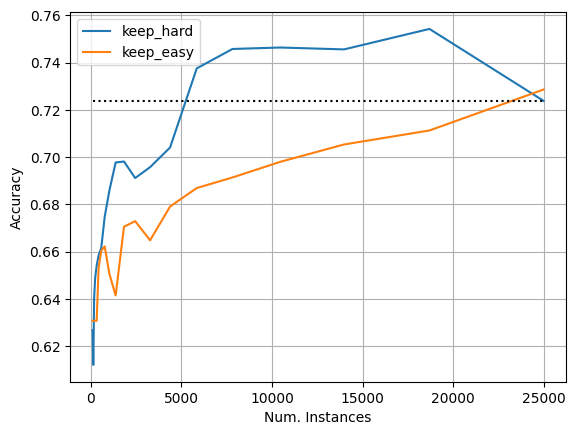

In [5]:
plt.plot(num_samp,np.mean(scores['knn']['keep_hard'], axis = 0), label = 'keep_hard')
plt.plot(num_samp,np.mean(scores['knn']['keep_easy'], axis = 0),label = 'keep_easy')
plt.plot([num_samp[0], num_samp[-1]], np.mean(scores['knn']['keep_hard'], axis = 0)[-1]*np.ones(2), ":k")
plt.xlabel("Num. Instances")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

We are able to improve model accuracy whilst training on ~10% of the original dataset.


**Prioritization**


In order to informatively visualize the effect of prioritization, we will plot the percent of the candidate set we select for labeling/training vs. the overall test set model accuracy.


In [6]:
num_fracs = 20
fracs = np.geomspace(0.99,0.01,num_fracs)
scores = np.zeros((num_fracs, num_bootstrap))
scores_easy = np.zeros((num_fracs, num_bootstrap))
train_frac = 0.7
res = ber(data["test"],labels["test"], method="KNN")
strats = ['keep_hard','keep_easy']
for k in strats:
    for j in range(num_bootstrap):
        row_inds = np.random.choice(np.arange(len(data["train"]),dtype=int), 25000, replace=False)
        X_emb_trn = data["train"].iloc[row_inds]
        X_lab = labels["train"].iloc[row_inds]
        inds = prioritize(X_emb_trn,data["cand"], strategy=k)
        for i in range(num_fracs):
            frac_ind = int(len(data["cand"])*fracs[i])
            ind_spec = inds[0:frac_ind]
            bigtrn = np.concatenate((X_emb_trn,data["cand"].iloc[ind_spec]))
            bigy = np.concatenate((X_lab, labels["cand"].iloc[ind_spec]))
            cls = RandomForestClassifier(max_depth=5)
            cls.fit(bigtrn,bigy)
            if k == 'keep_hard':
                scores[i,j] = cls.score(data["test"].values, labels["test"])
            else:
                scores_easy[i,j] = cls.score(data["test"].values, labels["test"])

Text(0, 0.5, 'Accuracy')

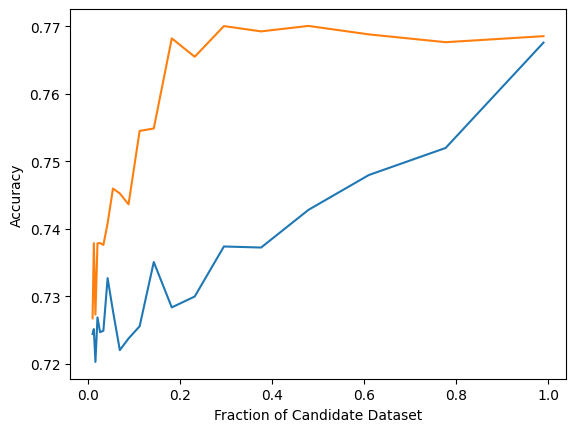

In [7]:
plt.plot(fracs,np.mean(scores_easy,axis =1))
plt.plot(fracs,np.mean(scores,axis =1))
plt.xlabel("Fraction of Candidate Dataset")
plt.ylabel("Accuracy")

In [8]:
inds = prioritize(X_emb_trn,data["cand"], strategy='keep_hard')

Text(0.5, 0.98, 'Candidate Data Selected First wrt Training Data (High Priority)')

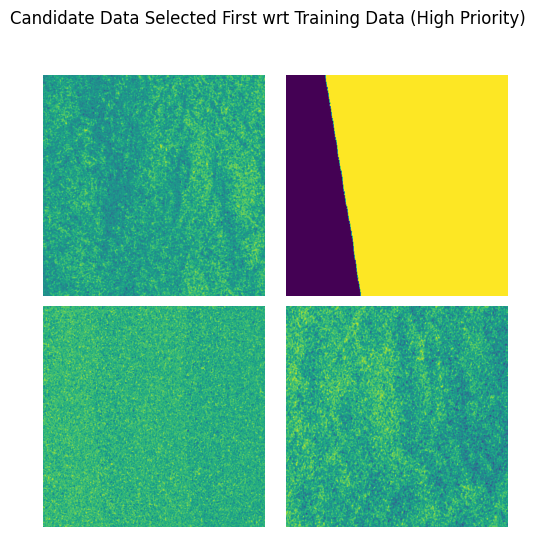

In [9]:
f,axs = plt.subplots(nrows=2,ncols=2, figsize=(6,6))
for rdx in range(2):
    for cdx in range(2):
        idx = rdx*2 + cdx+1
        cid = chip_ids["cand"][inds[idx]].item()
        sid = scene_ids["cand"][inds[idx]]
        img = np.load(f"/mnt/nas_device_0/xview3/chips_512_v2/validation/{sid}/vv/{cid}_vv.npy")
        axs[rdx,cdx].imshow(img)
        axs[rdx,cdx].axis("off")
plt.subplots_adjust(wspace=0.1, hspace=0)
plt.suptitle("Candidate Data Selected First wrt Training Data (High Priority)")

Text(0.5, 0.98, 'Candidate Data Selected Last wrt Training Data (Low Priority)')

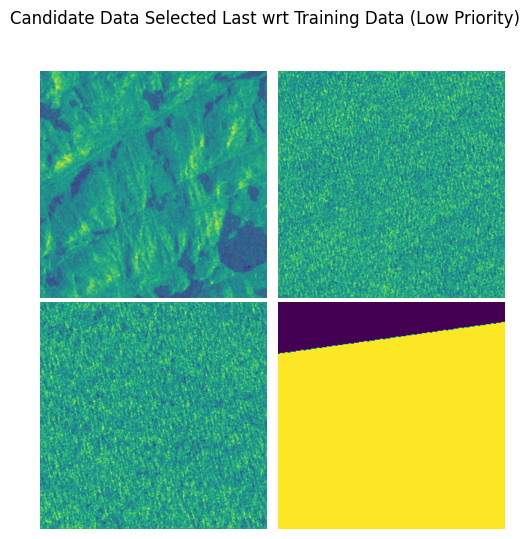

In [ ]:
f,axs = plt.subplots(nrows=2,ncols=2, figsize=(6,6))
for rdx in range(2):
    for cdx in range(2):
        idx = rdx*2 + cdx+1
        cid = chip_ids["cand"][inds[-idx]].item()
        sid = scene_ids["cand"][inds[-idx]]
        img = np.load(f"/mnt/nas_device_0/xview3/chips_512_v2/validation/{sid}/vv/{cid}_vv.npy")
        axs[rdx,cdx].imshow(img)
        axs[rdx,cdx].axis("off")
plt.subplots_adjust(wspace=0.05, hspace=0)
plt.suptitle("Candidate Data Selected Last wrt Training Data (Low Priority)")